In [5]:
from src.get_first_frame import *
from src.utils import *
from src.file_reading import *
from src.viz.images import *

from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

In [2]:
scale_imshow = lambda img: scaled_imshow(img,fx=0.4,fy=0.4)

In [6]:
img = get_first_frame('./data/easy/clip_0.mp4')
img = cv.resize(img,None,fx=0.4,fy=0.4)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

Detecting the dice tray. The dice tray is all black so a simple threshold should do the work

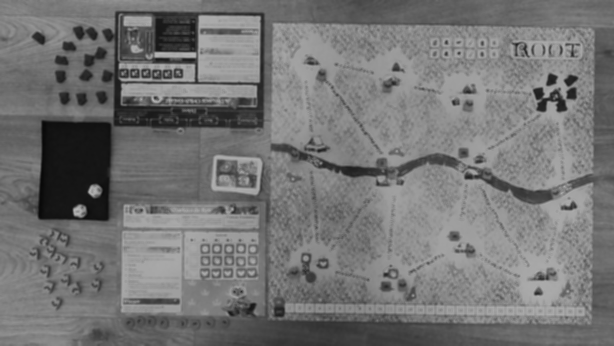

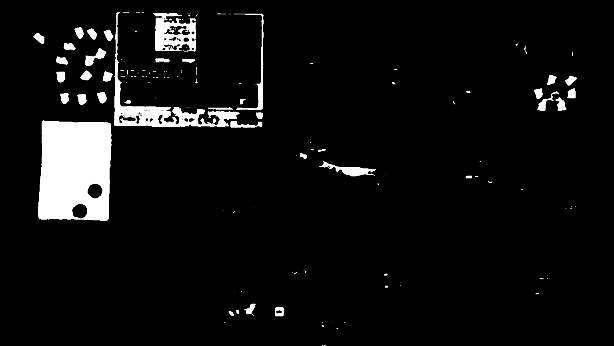

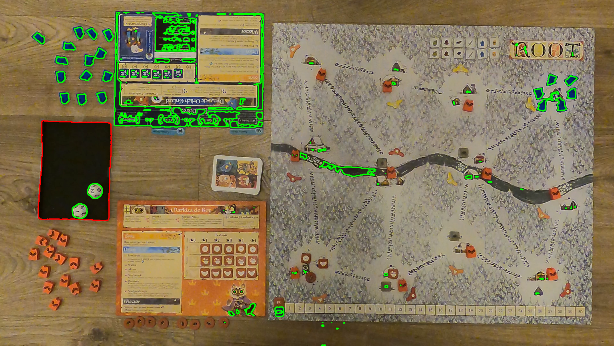

In [7]:
#cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(7,7),0)
filtered = cv.bilateralFilter(gray, 9, 250, 250) 
#filtered = cv2.medianBlur(filtered,3)

scale_imshow(filtered)

#edges = cv2.Canny(filtered, 50, 60)
#edges = cv2.morphologyEx(edges, cv2.MORPH_DILATE, np.ones((2,2)))
_,thresh = cv.threshold(filtered,50,255,cv.THRESH_BINARY)
thresh = 255-thresh

scale_imshow(thresh)

contours,hierarchy = cv.findContours(thresh, cv.RETR_TREE, 2)
i,largest_contour = max(enumerate(contours), key=lambda i_c:cv2.contourArea(i_c[1]))

# Draw the contours on the original image
img_contours = np.copy(img)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
cv2.drawContours(img_contours, [largest_contour], -1, (0, 0, 255), 2)

# Display the result
scale_imshow(img_contours)



Here we retrieve the dice from the contour hierarchy. The hierarchy used is *RETR_TREE*, which is described in [OpenCV docs](https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html). In short the hierarchy contains information about relations to other contours. It includes:
 - next contour (at the same height),
 - previous contour (at the same height),
 - child,
 - parent

Value of -1 indicates lack of another contour

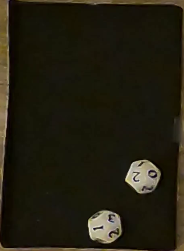

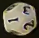

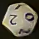

In [8]:
cropped = crop_contour(img,largest_contour)

imshow(cropped)

_,_,i_d1,_ = hierarchy[0,i]
i_d2,_,_,_ = hierarchy[0,i_d1]

dice1 = crop_contour(img,contours[i_d1])
dice2 = crop_contour(img,contours[i_d2])

imshow(dice1)
imshow(dice2)

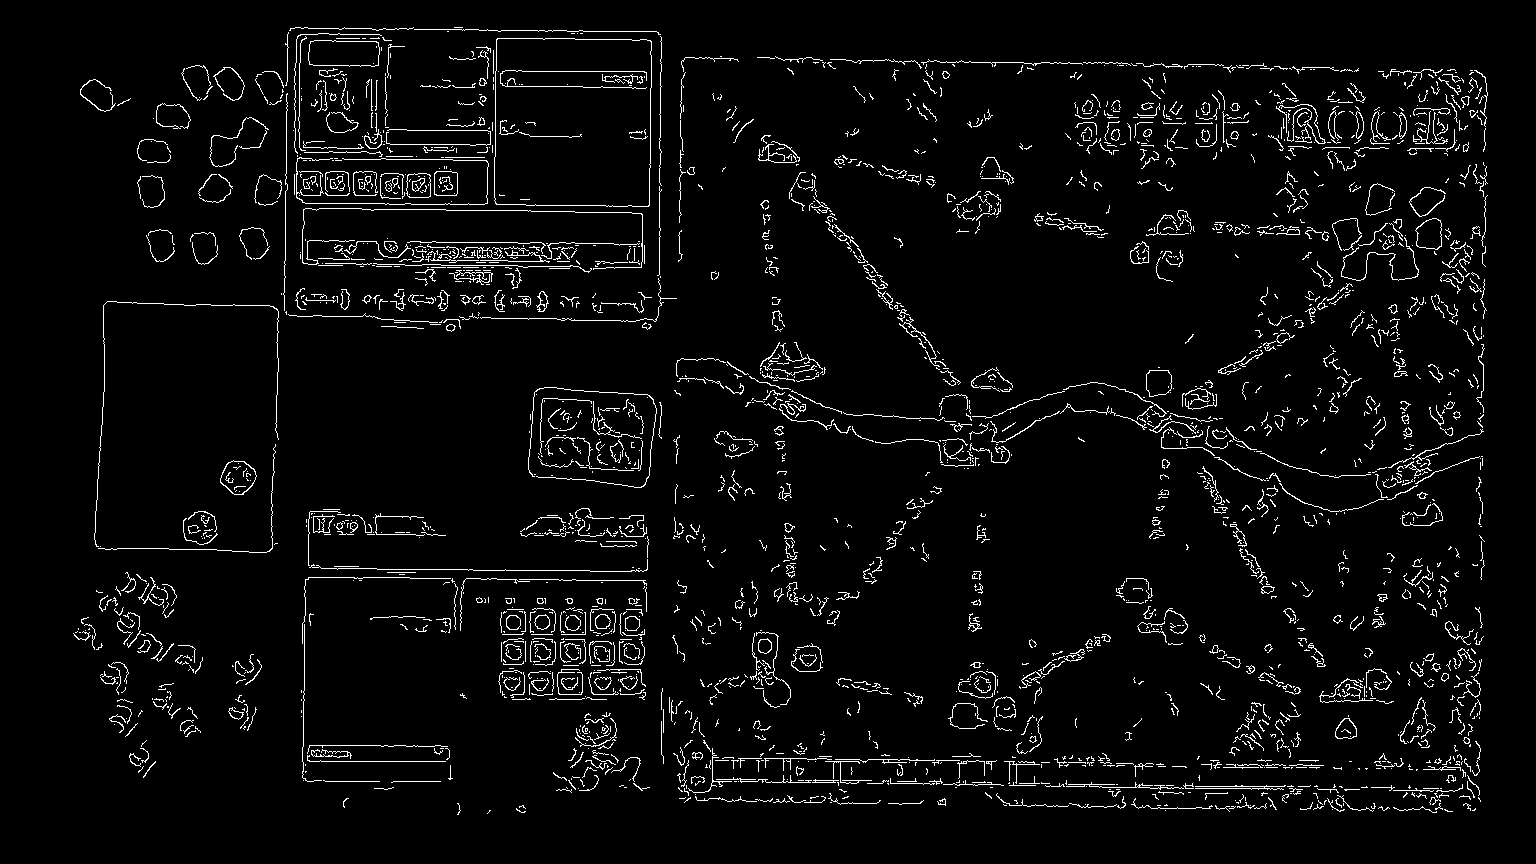

In [9]:
edges = cv2.Canny(filtered, 50, 80)

imshow(edges)

The main board is not solid color, instead there is artwork drawn on it. In order to locate it descriptors might be used.

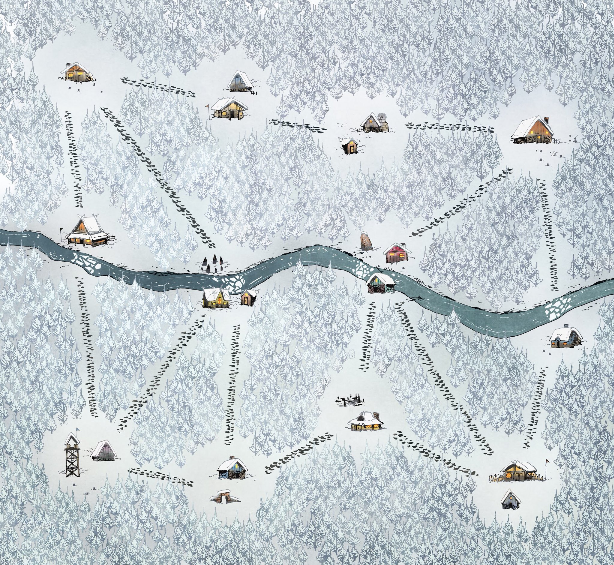

In [10]:
board_ref = cv.imread('data/game_data/board.jpg')
board_gray = cv.GaussianBlur(cv.cvtColor(board_ref, cv.COLOR_BGR2GRAY),(7,7),0)

scaled_imshow(board_ref)

In [11]:
sift = cv.SIFT_create()
kp, desc = sift.detectAndCompute(gray, None)

kp2, desc2 = sift.detectAndCompute(board_gray, None)

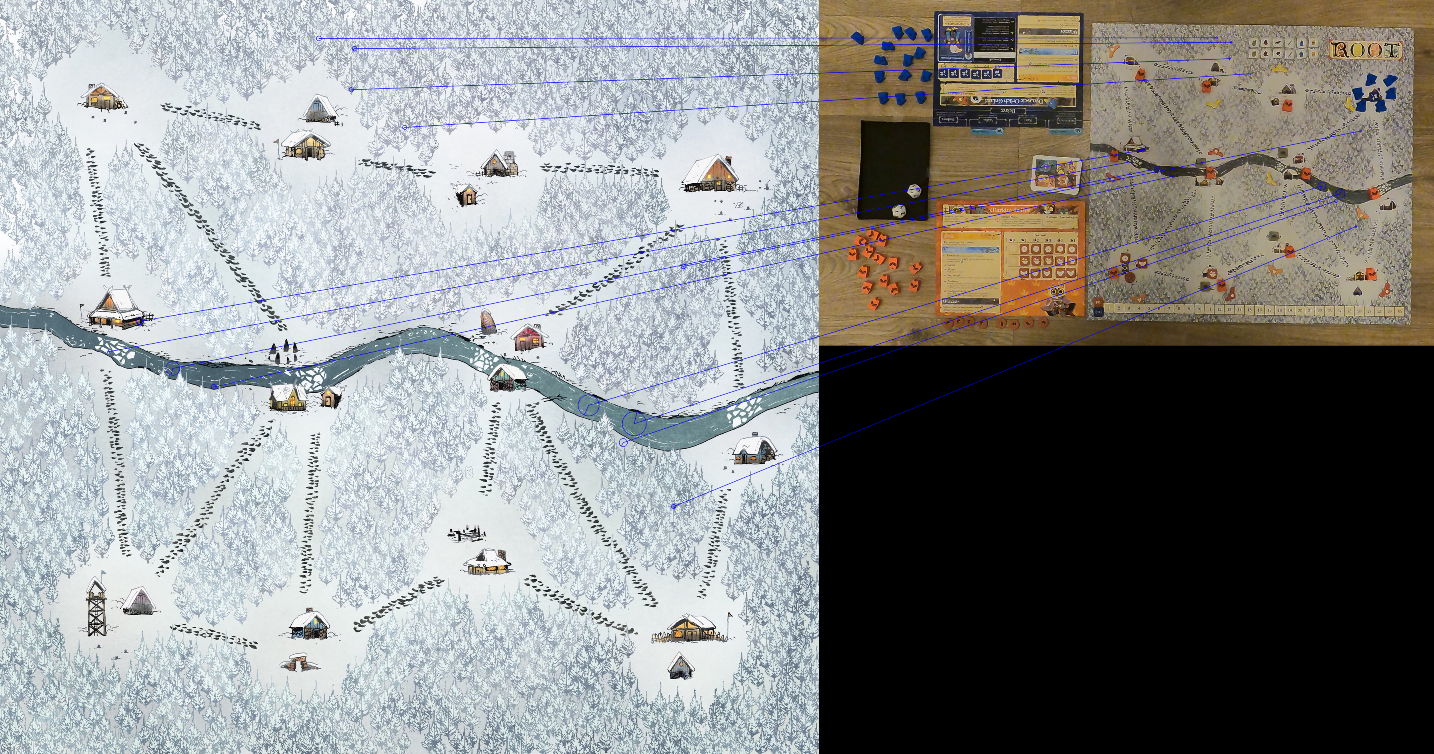

In [12]:
bf = cv.BFMatcher()
matches = bf.match(desc2, desc)

good_matches = sorted(matches, key=lambda x: x.distance)
_max =  max(matches, key=lambda x: x.distance).distance
good_matches = [m for m in matches if m.distance < 0.25 * _max]

src_pts = np.float32([kp2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
M, mask = cv.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

draw_params = dict(matchColor = (255,0,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = 2|4)
img3 = cv.drawMatches(board_ref,kp2,img,kp,good_matches,None,**draw_params)
scale_imshow(img3)

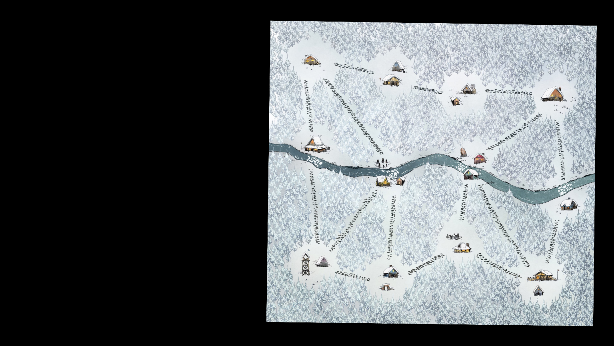

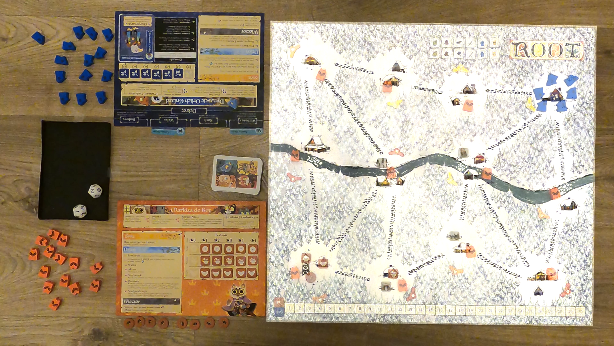

In [13]:
warped_board = cv.warpPerspective(board_ref, M, (img.shape[1], img.shape[0]))
scale_imshow(warped_board)

result = cv.addWeighted(img, 1, warped_board, 0.5, 0)

scale_imshow(result)

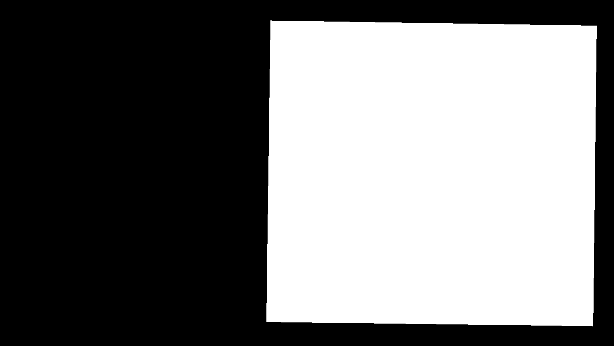

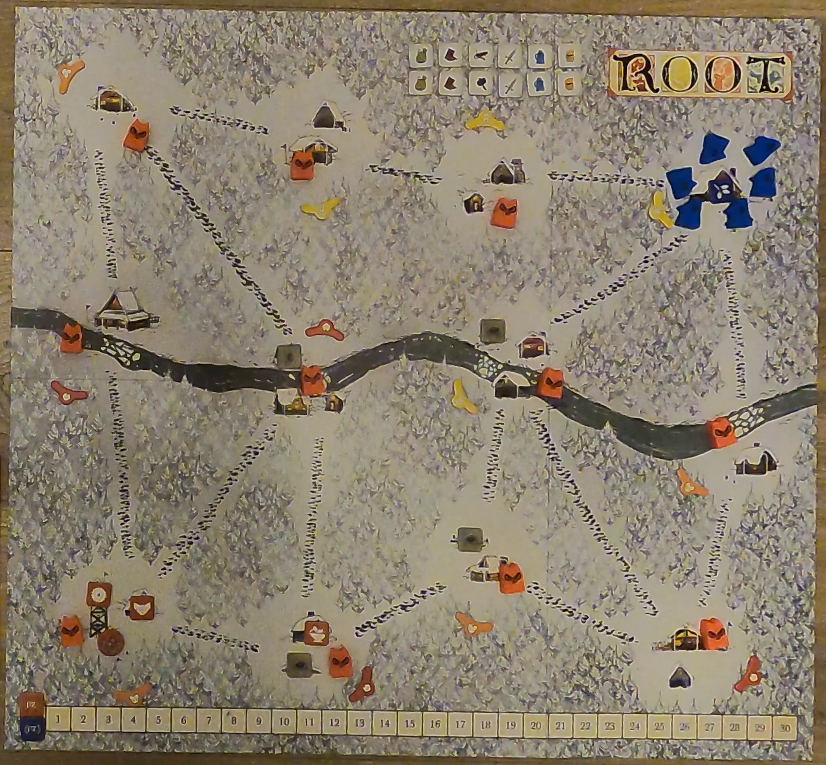

In [14]:
warped_gray = cv.cvtColor(warped_board,cv.COLOR_BGR2GRAY)
_,edges2 = cv.threshold(warped_gray,50,255,cv.THRESH_BINARY)
edges2 = cv.morphologyEx(edges2,cv.MORPH_CLOSE,kernel=np.ones((7,7)))

scale_imshow(edges2)

contours,hierarchy = cv.findContours(edges2, cv.RETR_TREE, 2)
i,largest_contour2 = max(enumerate(contours), key=lambda i_c:cv2.contourArea(i_c[1]))


crop_board = crop_contour(img,largest_contour2)
imshow(crop_board)

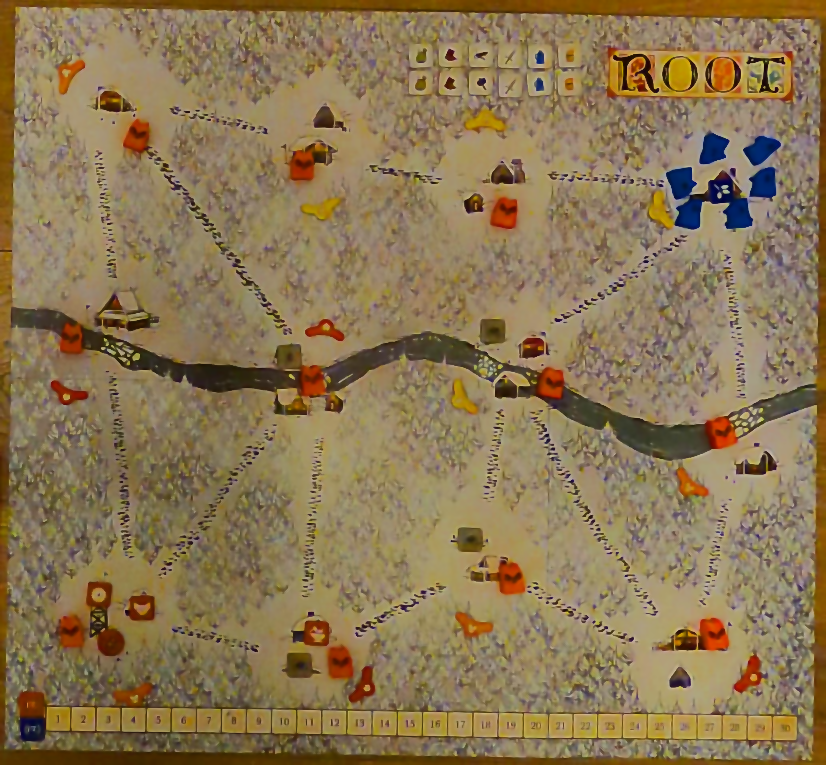

In [15]:
saturated = saturate_image(crop_board,2)
blurred = cv.bilateralFilter(saturated,5,150,150)
board_pix = saturated.reshape([-1,3])

imshow(blurred)

In [16]:
n = 9
model = GaussianMixture(n_components=n,
                        init_params="k-means++")
model.fit(board_pix)
segments = model.predict(board_pix)

In [ ]:
segment_colors = np.stack([board_pix[segments==i].mean(0) for i in range(n)],0)
colors =np.take(segment_colors,segments,0)
segmented = colors.reshape(crop_board.shape)
imshow(segmented)

In [ ]:
crop_ref = crop_contour(warped_board,largest_contour2)
imshow(np.absolute(crop_ref-crop_board))

In [ ]:
board_mask = cv.imread('data\\game_data\\board_mask.png')
imshow(board_mask)

In [ ]:
warp_mask = crop_contour(cv.warpPerspective(board_mask, M, (img.shape[1], img.shape[0])),largest_contour2)
scale_imshow(warp_mask)

In [ ]:
imshow(cv.bitwise_and(crop_board,crop_board,mask=warp_mask[:,:,0]))